In [1]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset
from strategies import LSTM_Strategy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\Artem\AppData\Local\Temp\ipykernel_29420\4031250555.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
USD = Asset.make_USD()
BTC = Asset('BTC')
#BTC.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
ETH = Asset('ETH')
#ETH.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
USDT = Asset('USDT')
#USDT.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2021-01-01'), date_to = tmpstemp('2024-03-31'))

In [3]:
naive_LSTM = LSTM_Strategy(model_input_length = 15)
date_from = tmpstemp('2022-01-01')
x_train, y_train, train_idx, x_val, y_val, val_idx = naive_LSTM.train_val_split_scale(BTC.history.loc[date_from:])

In [4]:
hidden_size = 50
dropout = 0.2
learning_rate = 0.0005

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]), name = 'input')

LSTM1 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM1' )(input_layer)
LSTM1 = Dropout(dropout)(LSTM1)

LSTM2 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM2' )(LSTM1)
LSTM2 = Dropout(dropout)(LSTM2)

LSTM3 = LSTM(units = 50, activation='tanh', name = 'LSTM3' )(LSTM2)
LSTM3 = Dropout(dropout)(LSTM3)
'''
hidden1 = Dense(hidden_size, activation='relu', name='hidden_layer1')(LSTM3)
hidden1 = Dropout(dropout)(hidden1)
'''

# Create output layer
out = Dense(1, activation='linear', name = 'Regression_layer')(LSTM3)
model = Model(inputs=[input_layer], outputs=out)

model.compile(optimizer=Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])
naive_LSTM.model = model
#naive_LSTM.model.summary()

#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

naive_LSTM.model.fit([x_train], y_train, 
          validation_data=([x_val], y_val),
          epochs=20, batch_size=64,
          callbacks=[early_stopping])

Epoch 1/20
9/9 [==============================] - 6s 165ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0538 - val_mean_squared_error: 0.0538
Epoch 2/20
9/9 [==============================] - 0s 25ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 3/20
9/9 [==============================] - 0s 25ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0291 - val_mean_squared_error: 0.0291
Epoch 4/20
9/9 [==============================] - 0s 26ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 5/20
9/9 [==============================] - 0s 26ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 6/20
9/9 [==============================] - 0s 27ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 7/20
9/9 [=============================

In [5]:
my_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
my_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

ref_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
ref_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

In [6]:
#pred_df = naive_LSTM.predict_batch(data_to_process = BTC.history['close'].loc[val_idx[0]-tmpdelta(days=14):])

In [28]:
def execute_suggestions(suggestions, portfolio):
    for ticker in suggestions.index:
        portfolio.update_transactions(ticker = str(ticker),
                                    qty =  suggestions['change_in_size'].loc[ticker],
                                    transaction_date = today,
                                    note =  suggestions['note'].loc[ticker])

pred_df = pd.DataFrame(data=[],
                        columns = ['Predicted price'],
                        index = pd.DatetimeIndex([], name='date_time'))

#Find record in BTC history that is closest to the origin date of the portfolio
first_date = min(BTC.history.index, key=lambda x: abs(x - my_portfolio.orig_date))
first_index = BTC.history.index.get_loc(first_date) + 1 
alloc = []
for today in BTC.history.index[first_index:-2]:
    tmr = today + tmpdelta(days=1)
    alloc.append(my_portfolio.get_positions(today)['allocation'].loc['BTC'])
    today_data = BTC.history['close'].\
                        loc[today-tmpdelta(days=(naive_LSTM.input_span-1)):today]
    new_pred = naive_LSTM.predict_one(today_data)
    pred_df = pd.concat([pred_df, new_pred], axis = 0)
    suggestion = naive_LSTM.make_suggestion(today, my_portfolio)
    execute_suggestions(suggestion, my_portfolio)

my_portfolio.update_value(up_to=pred_df.index[-1])
ref_portfolio.update_value(up_to=pred_df.index[-1])

46969.63290433002
46969.63290433002
46745.70678464974
46745.70678464974
46307.59746052074
46307.59746052074
45964.461818619675
45964.461818619675
44683.84247241805
44683.84247241805
44488.72327062207
44488.72327062207
43641.39282247676
43641.39282247676
43706.769952187
43706.769952187
43814.76052212703
43814.76052212703
43781.83717967722
43781.83717967722
44331.30416242528
44331.30416242528
45031.916473860365
45031.916473860365
44212.49937043394
44212.49937043394
44525.442212363574
44525.442212363574
44528.083656214694
44528.083656214694
44529.97381272915
44529.97381272915
43958.450588471096
43958.450588471096
44055.201397608806
44055.201397608806
43595.71769602946
43595.71769602946
42926.1399346369
42926.1399346369
40087.74183969274
40087.74183969274
39138.40893664656
39138.40893664656
39975.62414303954
39975.62414303954
40260.6603648727
40260.6603648727
40461.29791914431
40461.29791914431
40360.2386254332
40360.2386254332
40609.25696564163
40609.25696564163
41010.6354978314
41010.635

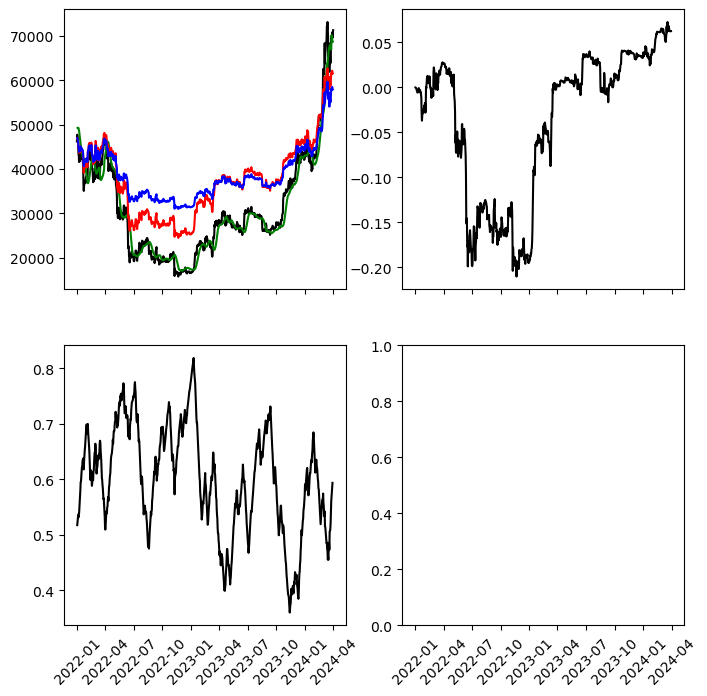

In [37]:
# Plot the results
fig, ax = plt.subplots(2, 2, sharex = True)
fig.set_figheight(8)
fig.set_figwidth(8)
actual_df = BTC.history.loc[first_date:]
ax[0,0].plot(actual_df.index, actual_df['close'], color = 'black', label = 'Actual')
ax[0,0].plot(pred_df.index, pred_df['Predicted price'], color = 'green', label = 'Predicted')
ax[0,0].plot(my_portfolio.value.index, my_portfolio.value['value'], color = 'red', label = 'Experimental Portfolio')
ax[0,0].plot(ref_portfolio.value.index, ref_portfolio.value['value'], color = 'blue', label = 'Reference Portfolio')
for tick in ax[0,0].get_xticklabels():
        tick.set_rotation(45)

ax[0,1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - ref_portfolio.value['value'])/ref_portfolio.value['value'], color = 'black', label = 'ROI')
for tick in ax[0,1].get_xticklabels():
        tick.set_rotation(45)

ax[1,0].plot(ref_portfolio.value.index[:-1], alloc, color = 'black', label = 'Portfolio Allocation')
for tick in ax[1,0].get_xticklabels():
        tick.set_rotation(45)

for tick in ax[1,1].get_xticklabels():
        tick.set_rotation(45)